# Days exceedence by basin

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom3D, calc_fvcom_stat, extract_fvcom_level

# Updated method using KC results

In [2]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
DO_thresh = gdf['DO_std']
DO_thresh.shape

(7494,)

In [3]:
np_operator='min'
model_var='DOXG'
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var
# get list of run sub-directories in processed netcdf directory
dir_list = os.listdir(processed_netcdf_dir)

# Load all bottom DO values into dictionary

In [4]:
MinBottomDO_full={}
for run_dir in dir_list:
    try: 
        run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_{np_operator}_{model_var}_bottom.nc'
        with xarray.open_dataset(run_file) as ds:
            print([*ds])
            MinBottomDO_full[run_dir]=ds[f'{model_var}_daily_{np_operator}_bottom']
            print(MinBottomDO_full[run_dir].shape)
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')
        # create empty placeholder for now
        MinBottomDO_full[run_dir]=np.ones((361, 16012))*9999

['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)
['DOXG_daily_min_bottom']
(361, 16012)


## Sub-sample basin footprint

In [5]:
%%time
MinBottDO={}
MinBottDO_sorted={}
for run_tag in dir_list:
    MinBottDO[run_tag]=MinBottomDO_full[run_tag][:,gdf['node_id']-1]
    [ti,ni]= MinBottDO[run_tag].shape
    # add depth to array to sort nodes by depth
    tmp=np.vstack((gdf.depth,MinBottDO[run_tag]))
    # sort array based on the first row, which is depth
    tmp2=np.zeros(tmp.shape)
    for ii in range(0,ti):
        tmp2[ii:]=tmp[ii,tmp[0, :].argsort()]
    # now remove the depth values and save as a sorted-by-depth array
    MinBottDO_sorted[run_tag]=np.delete(tmp2,[0],0)
    # set nodes with include_i=0 to NaN
    #MinBottDO_sorted[run_tag][:,gdf['included_i']==0]=np.nan
    if np.min(MinBottDO[run_tag])==9999:
        print(f'{run_tag} min value: {np.min(MinBottDO[run_tag])}')
    else:
        print(f'{run_tag} min value: {np.min(MinBottDO[run_tag].values)}')
    

1c_all_sog_riv_off min value: 2.3595900984219043e-06
2b_sog_river_2times min value: 2.3576199055241887e-06
wqm_baseline min value: 2.358590108997305e-06
2a_sog_river_0.5times min value: 2.3590901037096046e-06
1d_small_sog_wwtp_off min value: 2.358619894948788e-06
1e_med_sog_wwtp_off min value: 2.358679921599105e-06
1b_all_sog_wwtp_off min value: 2.358699930482544e-06
CPU times: user 7.33 s, sys: 52.3 s, total: 59.7 s
Wall time: 1min


## Create boolean where MinDO < threshold

In [6]:
nnodes = len(DO_thresh)
ndays=361 # first 5-days are consisdered spin-up and have been removed
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
# (7494,361) x (7494,1) => element-wise multiplication 

In [7]:
Anoxic={}
for run_type in dir_list:
    print(run_type)
    Anoxic[run_type] = MinBottDO_sorted[run_type]<=DO_thresh2D.transpose() #361x7494 (nodes x time)
    AnoxicDays[run_type]=Anoxic[run_type].sum(axis=0) #7494 (nodes)

1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off


In [8]:
MinBottDO_sorted[run_type].shape

(361, 7494)

## Create a scatter plot of min bottom DO for Baseline to get a sense of values

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


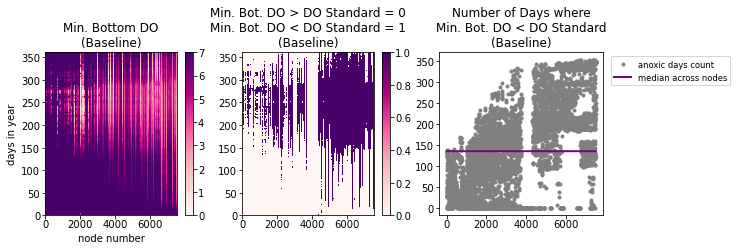

In [9]:
run_name = 'wqm_baseline'

fig, axs = plt.subplots(1,3, figsize = (10,3))
# Bottom DO    
botDO=axs[0].pcolormesh(MinBottDO_sorted[run_name],cmap='RdPu', vmin=0, vmax=7)
axs[0].set_title('Min. Bottom DO\n(Baseline)')
axs[0].set_xlabel('node number')
axs[0].set_ylabel('days in year')
# Anoxic days/nodes
anox=axs[1].pcolormesh(Anoxic[run_name],cmap='RdPu', vmin=0, vmax=1)
axs[1].set_title('Min. Bot. DO > DO Standard = 0\nMin. Bot. DO < DO Standard = 1\n(Baseline)')

axs[2].plot(AnoxicDays['wqm_baseline'],
            '.',color='grey',label='anoxic days count')
axs[2].plot(np.ones(7494,)*np.median(AnoxicDays[run_name]),
            '-',color='purple',linewidth=2,label='median across nodes')
axs[2].set_title('Number of Days where\nMin. Bot. DO < DO Standard\n(Baseline)')
axs[2].legend(bbox_to_anchor=(1.8, 1), loc='upper right')
cb0=fig.colorbar(botDO, ax=axs[0])
cb1=fig.colorbar(anox, ax=axs[1])
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'Baseline_anoxia.png',
                bbox_inches='tight',format='png')

#### same as above but with masked areas removed

In [10]:
for run_tag in dir_list:
    # set nodes with include_i=0 to NaN
    MinBottDO_sorted[run_tag][:,gdf['included_i']==0]=np.nan
    Anoxic[run_tag] = MinBottDO_sorted[run_tag]<=DO_thresh2D.transpose() #361x7494 (nodes x time)
    AnoxicDays[run_tag]=Anoxic[run_tag].sum(axis=0)

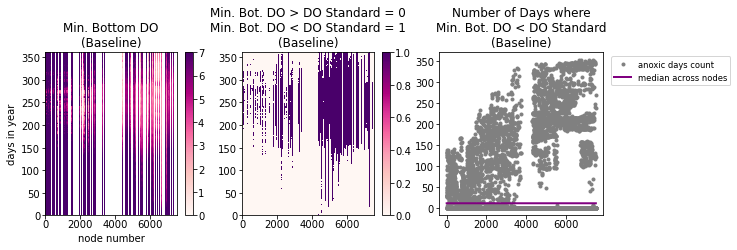

In [11]:
run_name = 'wqm_baseline'

fig, axs = plt.subplots(1,3, figsize = (10,3))
# Bottom DO    
botDO=axs[0].pcolormesh(MinBottDO_sorted[run_name],cmap='RdPu', vmin=0, vmax=7)
axs[0].set_title('Min. Bottom DO\n(Baseline)')
axs[0].set_xlabel('node number')
axs[0].set_ylabel('days in year')
# Anoxic days/nodes
anox=axs[1].pcolormesh(Anoxic[run_name],cmap='RdPu', vmin=0, vmax=1)
axs[1].set_title('Min. Bot. DO > DO Standard = 0\nMin. Bot. DO < DO Standard = 1\n(Baseline)')

axs[2].plot(AnoxicDays['wqm_baseline'],
            '.',color='grey',label='anoxic days count')
axs[2].plot(np.ones(7494,)*np.median(AnoxicDays[run_name]),
            '-',color='purple',linewidth=2,label='median across nodes')
axs[2].set_title('Number of Days where\nMin. Bot. DO < DO Standard\n(Baseline)')
axs[2].legend(bbox_to_anchor=(1.8, 1), loc='upper right')
cb0=fig.colorbar(botDO, ax=axs[0])
cb1=fig.colorbar(anox, ax=axs[1])
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'Baseline_anoxia_masked.png',
                bbox_inches='tight',format='png')

## Create pandas dataframe with Anoxic days by basin

#### Re-create anoxic days based on UNSORTED min bottom DO

In [12]:
Anoxic={}
for run_type in dir_list:
    print(run_type)
    Anoxic[run_type] = MinBottDO[run_type]<=DO_thresh2D.transpose() #361x7494 (nodes x time)
    AnoxicDays[run_type]=Anoxic[run_type].sum(axis=0) #7494 (nodes)

1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off


In [13]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in dir_list:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].sum()

In [14]:
## Repeat to calculate median and min
MedianDiff={}
MinDiff={}
MaxDiff={}
AnoxicDaysDiff={}
for run_type in dir_list:
    MedianDiff[run_type]={}
    MinDiff[run_type]={}
    MaxDiff[run_type]={}
    # Difference in total number of anoxic days for each cell
    AnoxicDaysDiff[run_type] = AnoxicDays['wqm_baseline']-AnoxicDays[run_type]
    for basin in basins:
        # calculate the difference in number of anoxic days per cell
        MedianDiff[run_type][basin]=np.median(np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ])
        MinDiff[run_type][basin]=np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].min()
        MaxDiff[run_type][basin]=np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].max()

## Plot differences in the number of Anoxic days

In [15]:
[*AnoxicDaysDiff]

['1c_all_sog_riv_off',
 '2b_sog_river_2times',
 'wqm_baseline',
 '2a_sog_river_0.5times',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off',
 '1b_all_sog_wwtp_off']

In [16]:
[*ssm]

['bar',
 'line',
 'paths',
 'run_index',
 'run_information',
 'run_tag',
 'siglev_diff',
 'stations',
 'variables']

In [17]:
ssm['run_information']['run_tag']

{'1b_all_sog_wwtp_off': '1b',
 '1c_all_sog_riv_off': '1c',
 '1d_small_sog_wwtp_off': '1d',
 '1e_med_sog_wwtp_off': '1e',
 '2a_sog_river_0.5times': '2a',
 '2b_sog_river_2times': '2b',
 'wqm_baseline': 'Baseline'}

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


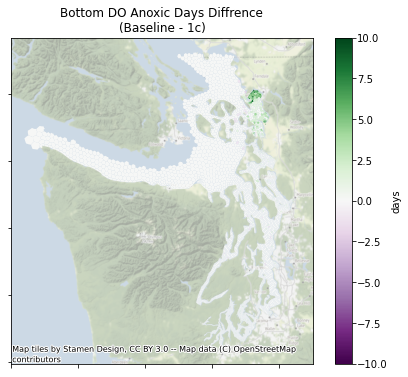

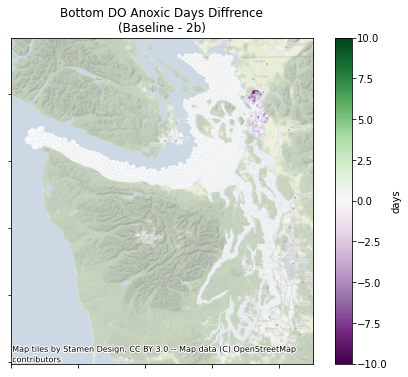

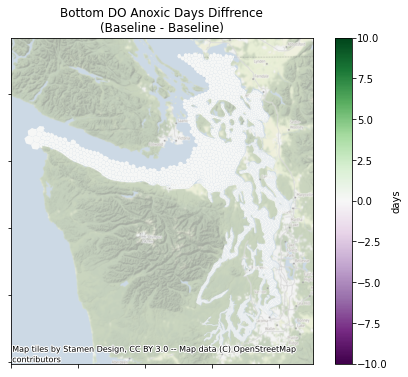

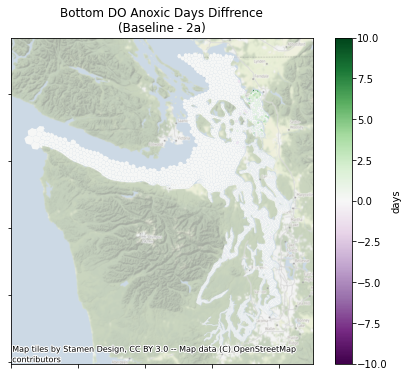

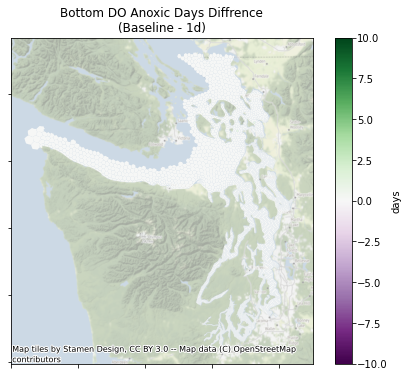

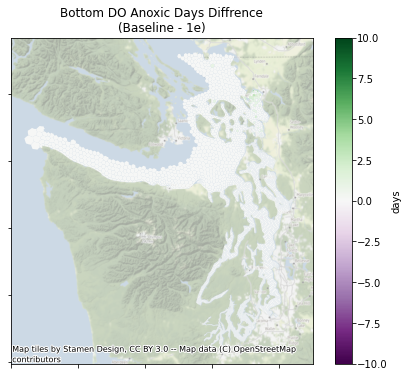

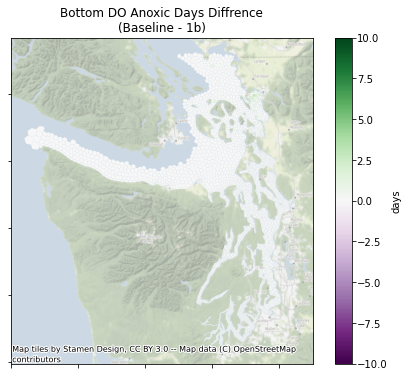

In [18]:
for idx,run in enumerate([*AnoxicDaysDiff]):
    #
    fig_title = f"Bottom DO Anoxic Days Diffrence\n(Baseline - {ssm['run_information']['run_tag'][run]})"
    graphics_name = f"AnoxDiff_Baseline_minus_{ssm['run_information']['run_tag'][run]}.png"
    gdf_col_name=f"days_diff_{ssm['run_information']['run_tag'][run]}"
    # add differences in anoxic days to geodataframe
    gdf[gdf_col_name]=AnoxicDaysDiff[run]
    # plot differences for each run
    fig, axs = plt.subplots(1,1, figsize = (8,6))
    gdf.plot(gdf_col_name, ax=axs, legend=True,vmin=-10,vmax=10,cmap='PRGn')
    cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
    # Zoom into Bbay so we can actualy see overlap
    #axs.set_ylim(5.37e6,5.42e6)
    #axs.set_xlim(5e5,5.4e5)
    #xlabels=axs.get_xticklabels()
    axs.set_title(fig_title)
    axs.set_xticklabels('')
    axs.set_yticklabels('')
    # Get colourbar from second axis
    colorbar = axs.get_figure().get_axes()[1]
    colorbar.set_ylabel('days')
    plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
                bbox_inches='tight',format='png')
    # axs.text(5.01e5,5.386e6,"Orcas Is.")
    # axs.text(5.3e5,5.405e6,"Nooksack R.")
    # axs.text(5.18e5,5.415e6,"Pt. Whitehorn")

## Plot number of anoxic days for Baseline run

In [19]:
np.arange(0,401,50)

array([  0,  50, 100, 150, 200, 250, 300, 350, 400])

In [20]:
interval={}
gdf_anoxicDays={}
for ii in np.arange(0,365,50):
    print(f'{ii},{ii+50-1}')
    interval[f'{ii}-{ii+50-1}']=(AnoxicDays['wqm_baseline']>ii) & (AnoxicDays['wqm_baseline']<ii+50)
    gdf_anoxicDays[f'{ii}-{ii+50-1}']=gdf[interval[f'{ii}-{ii+50-1}'].values]
# vals=(AnoxicDays['wqm_baseline']<250)

0,49
50,99
100,149
150,199
200,249
250,299
300,349
350,399


In [21]:
cool =  mpl.cm.get_cmap('cool', 8)

In [22]:
c_arr=cool(range(8))
c_arr

array([[0.        , 1.        , 1.        , 1.        ],
       [0.14285714, 0.85714286, 1.        , 1.        ],
       [0.28571429, 0.71428571, 1.        , 1.        ],
       [0.42857143, 0.57142857, 1.        , 1.        ],
       [0.57142857, 0.42857143, 1.        , 1.        ],
       [0.71428571, 0.28571429, 1.        , 1.        ],
       [0.85714286, 0.14285714, 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ]])

In [23]:
c_arr.shape

(8, 4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0, 5150000.0, ''),
 Text(0, 5200000.0, ''),
 Text(0, 5250000.0, ''),
 Text(0, 5300000.0, ''),
 Text(0, 5350000.0, ''),
 Text(0, 5400000.0, ''),
 Text(0, 5450000.0, '')]

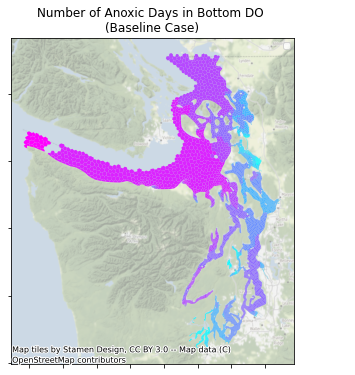

In [24]:
fig_title = f"Number of Anoxic Days in Bottom DO \n(Baseline Case)"
graphics_name = f"AnoxDays_Baseline.png"
gdf_col_name=f"days_anoxic_baseline"
# add differences in anoxic days to geodataframe
#gdf[gdf_col_name]=AnoxicDays['wqm_baseline']
# plot differences for each run
fig, axs = plt.subplots(1,1, figsize = (8,6))
for idx,ii in enumerate(np.arange(0,365,50)):
    gdf_anoxicDays[f'{ii}-{ii+50-1}'].plot(ax=axs, 
                                           legend=True,
                                           color=c_arr[idx,:],
                                           label=f'{ii}-{ii+50-1}')
plt.legend()
cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
# Zoom into Bbay so we can actualy see overlap
#axs.set_ylim(5.37e6,5.42e6)
#axs.set_xlim(5e5,5.4e5)
#xlabels=axs.get_xticklabels()
axs.set_title(fig_title)
axs.set_xticklabels('')
axs.set_yticklabels('')
# Get colourbar from second axis
#colorbar = axs.get_figure().get_axes()[1]
#colorbar.set_ylabel('days')
#plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
#            bbox_inches='tight',format='png')


In [25]:
np.median(AnoxicDays['wqm_baseline'])

163.0

In [26]:
np.sum((AnoxicDays['wqm_baseline']>350))

<xarray.DataArray 'DOXG_daily_min_bottom' ()>
array(21)

In [27]:
## Map of DO_std

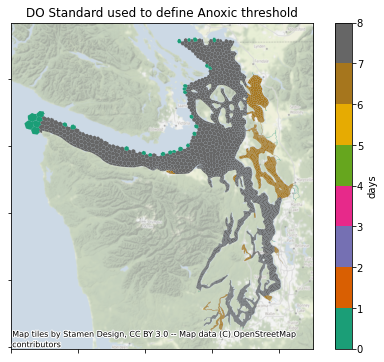

In [28]:
fig_title = f"DO Standard used to define Anoxic threshold"
graphics_name = f"DO_std.png"
# plot differences for each run
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('DO_std', ax=axs, legend=True,vmin=0,vmax=8,cmap='Dark2')
cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
# Zoom into Bbay so we can actualy see overlap
#axs.set_ylim(5.37e6,5.42e6)
#axs.set_xlim(5e5,5.4e5)
#xlabels=axs.get_xticklabels()
axs.set_title(fig_title)
axs.set_xticklabels('')
axs.set_yticklabels('')
# Get colourbar from second axis
colorbar = axs.get_figure().get_axes()[1]
colorbar.set_ylabel('days')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
            bbox_inches='tight',format='png')



## Create and format dataframes

In [29]:
# Total number of anoxic days by basin and run
TotalAnoxic_df=pandas.DataFrame(TotalAnoxic)
TotalAnoxic_df=TotalAnoxic_df.rename(columns=ssm['run_information']['run_tag'])
TotalAnoxic_df = TotalAnoxic_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Median number of difference in anoxic days by run
MedianDiff_df = pandas.DataFrame(MedianDiff)
MedianDiff_df = MedianDiff_df.rename(columns=ssm['run_information']['run_tag'])
MedianDiff_df = MedianDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Min number of difference
MinDiff_df = pandas.DataFrame(MinDiff)
MinDiff_df = MinDiff_df.rename(columns=ssm['run_information']['run_tag'])
MinDiff_df = MinDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Max number of difference
MaxDiff_df = pandas.DataFrame(MaxDiff)
MaxDiff_df = MaxDiff_df.rename(columns=ssm['run_information']['run_tag'])
MaxDiff_df = MaxDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b']) 

## Create a dataframe showing percent change in days below threshold

In [30]:
# create empty dataframe to place baseline value and percent change for all other runs
PercentChangeAnoxic = pandas.DataFrame().reindex_like(TotalAnoxic_df)
PercentChangeAnoxic['Baseline']=TotalAnoxic_df['Baseline']

# create a list of the runs for which to calculate % change
change_list=TotalAnoxic_df.columns.to_list()
change_list.remove('Baseline')
# calculate percent change
baseline='Baseline' #defined as 'wqm_baseline'
for change in change_list:
    PercentChangeAnoxic[change]=100*(
        (TotalAnoxic_df[change]-TotalAnoxic_df[baseline])/TotalAnoxic_df[baseline]
    )
# PercentChangeAnoxic['1b_all_sog_wwtp_off']=100*(
#     (TotalAnoxic_df['1b_all_sog_wwtp_off']-TotalAnoxic_df['wqm_baseline'])/TotalAnoxic_df['wqm_baseline']
# )
PercentChangeAnoxic

,Baseline,1b,1c,1d,1e,2a,2b
Hood_Canal,95780,-0.002088,0.004176,0.000000,-0.001044,0.002088,0.002088
Main_Basin,162188,-0.003083,-0.016031,0.000000,-0.001850,-0.006782,0.017264
SJF_Admiralty,227235,-0.000440,-0.000440,0.000000,-0.000440,0.000440,-0.002640
SOG_Bays,118419,-0.035467,-0.147780,-0.002533,-0.033778,-0.065868,0.147780
South_Sound,128193,-0.010921,-0.039004,-0.003120,-0.007021,-0.021062,0.055385
Whidbey_Basin,76338,-0.006550,-0.044539,-0.001310,-0.006550,-0.015720,0.048469


In [31]:
PercentChangeAnoxic=PercentChangeAnoxic.rename(columns=ssm['run_information']['run_tag'])
PercentChangeAnoxic = PercentChangeAnoxic.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
PercentChangeAnoxic

,Baseline,1b,1c,1d,1e,2a,2b
Hood_Canal,95780,-0.002088,0.004176,0.000000,-0.001044,0.002088,0.002088
Main_Basin,162188,-0.003083,-0.016031,0.000000,-0.001850,-0.006782,0.017264
SJF_Admiralty,227235,-0.000440,-0.000440,0.000000,-0.000440,0.000440,-0.002640
SOG_Bays,118419,-0.035467,-0.147780,-0.002533,-0.033778,-0.065868,0.147780
South_Sound,128193,-0.010921,-0.039004,-0.003120,-0.007021,-0.021062,0.055385
Whidbey_Basin,76338,-0.006550,-0.044539,-0.001310,-0.006550,-0.015720,0.048469


In [32]:
col_short=PercentChangeAnoxic.columns.to_list()
col_short_wpercent=[f"{name} [% change]" for name in col_short if name!="Baseline"]
col_short_wpercent.insert(0,"Baseline")
col_title = {col_short[i]: col_short_wpercent[i] for i in range(len(col_short))}
col_title

{'Baseline': 'Baseline',
 '1b': '1b [% change]',
 '1c': '1c [% change]',
 '1d': '1d [% change]',
 '1e': '1e [% change]',
 '2a': '2a [% change]',
 '2b': '2b [% change]'}

In [33]:
PercentChangeAnoxic = PercentChangeAnoxic.rename(columns=col_title)
PercentChangeAnoxic

,Baseline,1b [% change],1c [% change],1d [% change],1e [% change],2a [% change],2b [% change]
Hood_Canal,95780,-0.002088,0.004176,0.000000,-0.001044,0.002088,0.002088
Main_Basin,162188,-0.003083,-0.016031,0.000000,-0.001850,-0.006782,0.017264
SJF_Admiralty,227235,-0.000440,-0.000440,0.000000,-0.000440,0.000440,-0.002640
SOG_Bays,118419,-0.035467,-0.147780,-0.002533,-0.033778,-0.065868,0.147780
South_Sound,128193,-0.010921,-0.039004,-0.003120,-0.007021,-0.021062,0.055385
Whidbey_Basin,76338,-0.006550,-0.044539,-0.001310,-0.006550,-0.015720,0.048469


In [34]:
col_short=PercentChangeAnoxic.columns.to_list()
col_short_wpercent=[f'{name} [% change]' for name in col_short if name!="Baseline"]
col_short_wpercent.insert(0,"Baseline")
col_short_wpercent

['Baseline',
 '1b [% change] [% change]',
 '1c [% change] [% change]',
 '1d [% change] [% change]',
 '1e [% change] [% change]',
 '2a [% change] [% change]',
 '2b [% change] [% change]']

## save to file

In [35]:
import openpyxl
excel_output_path = ssm['paths']['processed_output']
with pandas.ExcelWriter(pathlib.Path(excel_output_path)/'AnoxicDays.xlsx', mode='w') as writer:  
    TotalAnoxic_df.to_excel(writer, sheet_name='Total_Anoxic_Days')
    PercentChangeAnoxic.to_excel(writer, sheet_name='Percent_Change')
    MedianDiff_df.to_excel(writer, sheet_name='Median_Num_Days_Diff')
    MinDiff_df.to_excel(writer, sheet_name='Min_Num_Days_Diff')
    MaxDiff_df.to_excel(writer, sheet_name='Max_Num_Days_Diff')

# Method using 2014 output below

In [36]:
output_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data')
graphics_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics')

# Load netcdf of min daily DO on bottom level
These netcdf were output from `dev_TS_ExistRef_graphic.ipynb`

In [37]:
%%time
MinDO={}
idx=0
# loop through comparison cases and get timeseries from model output
for run_type in ['deviation','baseline']:
    print(run_type)
    xr=xarray.open_dataset(
        output_dir/f'dailyDO_tmin_bottom_{run_type}.nc'
    )
    MinDO[run_type]=xr.DailyMinBottomDO

deviation
baseline
CPU times: user 5.5 ms, sys: 3.73 ms, total: 9.23 ms
Wall time: 18.4 ms


In [38]:
MinDO[run_type].shape

(365, 16012)

# Load DO threshold information

In [39]:
# with open('../etc/SSM_config.yaml', 'r') as file:
#     ssm = yaml.safe_load(file)
# # get shapefile path    
# shp = ssm['shapefile_path']
# # load shapefile into geopandas dataframe
# gdf = gpd.read_file(shp)
# gdf.head(1)

In [40]:
# DO_thresh = gdf['DO_std']
# DO_thresh.shape

# Sub-sample model output with shapefile nodes
Assumption: array index = node_id -1
Why?  node_id = [1,16012], array index = [0,16012)

In [41]:
MinDO[run_type].shape

(365, 16012)

In [42]:
%%time
MinDO_basins={}
for run_type in ['deviation','baseline']:
    run_type
    MinDO_basins[run_type]=MinDO[run_type][:,gdf['node_id']-1]

CPU times: user 1.02 ms, sys: 43 µs, total: 1.06 ms
Wall time: 1.08 ms


In [43]:
MinDO_basins[run_type].shape

(365, 7494)

# Create boolean where MinDO < threshold

In [44]:
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
# (7494,365) x (7494,1) => element-wise multiplication
for run_type in ['deviation','baseline']:
    run_type
    Anoxic = MinDO_basins[run_type].transpose()<=DO_thresh2D
    AnoxicDays[run_type]=Anoxic.sum(axis=1)

In [45]:
AnoxicDays[run_type].median()

<xarray.DataArray 'DailyMinBottomDO' ()>
array(162.)

# Create pandas dataframe with Anoxic days by basin

In [46]:
gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()

['Hood_Canal',
 'Main_Basin',
 'SJF_Admiralty',
 'SOG_Bays',
 'South_Sound',
 'Whidbey_Basin']

In [47]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[gdf['Basin']==basin].sum()

In [48]:
pandas.DataFrame(TotalAnoxic)

,deviation,baseline
Hood_Canal,222270,220923
Main_Basin,215083,203937
SJF_Admiralty,320815,320257
SOG_Bays,199846,199058
South_Sound,185479,173016
Whidbey_Basin,157313,147070


#### The above is total days where bottom DO < threshold, by basin, with "deviation" reflecting "existing" and "baseline" as "reference"

# Calculate volume days exceedence

In [49]:
%%time
# specify variable to plot
graphic_var = 'DO'
# get correspoding model variable name, Var_10, for "DO"
ssm_var_name = ssm['var_name'][graphic_var]

for run_type in ['deviation','baseline']:
    # input netcdf filename
    index = ssm['run_index'][run_type]
    path=pathlib.Path(
        ssm['output_paths'][index])/'s_hy_base000_pnnl007_nodes.nc'
    print(path.as_posix())
    # load variable into xarray and calculate daily min.
    with xarray.open_dataset(path) as ds:
        dailyDO = reshape_fvcom(
            ds[ssm_var_name][:,:].data, 
            'days'
        ) #return (365x24xnodes)
    # calculate daily minimum (365 x nodes)
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # save to file
    xr_minDO=xarray.DataArray(dailyDO_tmin_rshp, name='DailyMinDO')
    xr_minDO.to_netcdf(output_dir/f'dailyDO_24hr_min_{run_type}.nc')

KeyError: 'var_name'

In [50]:
%%time
minDailyDO={}
for run_type in ['deviation','baseline']:
    netcdf_in = output_dir/f'dailyDO_24hr_min_{run_type}.nc'
    minDailyDO[run_type]=xarray.open_dataset(netcdf_in)

FileNotFoundError: [Errno 2] No such file or directory: b'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/dailyDO_24hr_min_deviation.nc'

In [51]:
minDailyDO[run_type].DailyMinDO.shape

KeyError: 'deviation'

## Use `gdf[node_id]-1` to get array indices 

In [ ]:
%%time
minDailyDO_shp={}
for run_type in ['deviation','baseline']:
    minDailyDO_shp[run_type]=minDailyDO[run_type].DailyMinDO[:,gdf['node_id']-1,:]

In [ ]:
minDailyDO_shp[run_type].shape

In [ ]:
minDailyDO_shp[run_type]

In [ ]:
minDailyDO_shp[run_type].transpose('dim_1','dim_0','dim_2').shape

## Calculate days exceedence for all layers

In [ ]:
DO_thresh = gdf['DO_std']
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)

In [ ]:
DO_thresh3D.shape

In [ ]:
DO_data = (DO_thresh3D>0)
DO_data.shape

In [ ]:
DO_data = (DO_thresh3D>0)
for depth in range(0,10):
    plt.plot(DO_thresh3D[:,1,depth][DO_data[:,1,depth]],'*')

In [ ]:
minDailyDO_shp[run_type].shape

In [ ]:
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)

In [ ]:
DO_thresh3D.shape

In [ ]:
%%time
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)# (7494,365) x (7494,1) => element-wise multiplication
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)
for run_type in ['deviation','baseline']:
    print(run_type)
    Anoxic = minDailyDO_shp[run_type]<=DO_thresh3D
    AnoxicDays[run_type]=Anoxic.sum(axis=0)

### Take the max boolean value across depth (i.e. 1 if there is(are) an anoxic level(s)) 

In [ ]:
np.sum(ssm['siglev_diff'])

In [ ]:
lyr_volume_np=(np.ones((10,7494))*gdf['volume'].values).T*ssm['siglev_diff']/100

In [ ]:
lyr_volume_time_np=np.ones((365,7494,10))*lyr_volume_np

In [ ]:
lyr_volume_time_np.shape

In [ ]:
%%time
nnodes = len(DO_thresh)
ndays=365
AnoxicVolDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)# (7494,365) x (7494,1) => element-wise multiplication
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)
for run_type in ['deviation','baseline']:
    print(run_type)
    Anoxic = np.squeeze([minDailyDO_shp[run_type]<=DO_thresh3D]*lyr_volume_time_np)
    AnoxicVolDays[run_type]=Anoxic.sum(axis=0).sum(axis=1)

In [ ]:
AnoxicVolDays[run_type].shape

In [ ]:
TotalVolAnoxicDays={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalVolAnoxicDays[run_type]={}
    for basin in basins:
        TotalVolAnoxicDays[run_type][basin]=np.array(AnoxicVolDays[run_type])[gdf['Basin']==basin].sum()

In [ ]:
pandas.DataFrame(TotalVolAnoxicDays).rename(columns={'deviation':'existing','baseline':'reference'})

###  Total volume [m^3] of depth levels with DO < DO_std in 2014

In [ ]:
np.array(AnoxicDays[run_type])[test].sum()

In [ ]:
np.array(AnoxicDays[run_type])[gdf['Basin']==basin].shape